In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import palettable.colorbrewer.sequential as pcs
import palettable.colorbrewer.diverging as pcd
import palettable.cartocolors.diverging as cartod
import palettable.cartocolors.sequential as cartos

from statsmodels.stats.outliers_influence import variance_inflation_factor



import libpysal

from esda.moran import Moran,Moran_Local

from spreg import OLS

from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR

from splot.esda import lisa_cluster

from patsy import dmatrices

In [2]:
# read in data
pre_df=pd.read_csv('data/lsoa_data.csv')
# lsoa geometry
boundary=gpd.read_file('data/LSOA_boundary/LDN-LSOAs.shp')

# merge two dataframes
gdf=gpd.GeoDataFrame(pre_df).merge(boundary,left_on='Codes',right_on='lsoa11cd')
# drop excessive columns
gdf=gdf.drop(['lsoa11cd','lsoa11nm','lsoa11nmw','objectid','st_areasha','st_lengths'],axis=1)

In [ ]:
# explore the structure of the data
gdf.describe()

In [3]:
gdf['kMedianHP']=gdf['MedianHP']/1000
gdf['kMedianHP'].describe()

count    4835.000000
mean      329.465551
std       215.083933
min         0.000000
25%       217.000000
50%       267.500000
75%       369.000000
max      3377.000000
Name: kMedianHP, dtype: float64

In [4]:
# remove lsoas wth no house price data
gdf=gdf[gdf['kMedianHP']>0].reset_index(drop=True)

In [ ]:
# Fig 1
fig,ax=plt.subplots(1,figsize=(12,10))

gdf.plot(column='kMedianHP',scheme='fisherjenks',cmap=cartos.Magenta_5.mpl_colormap,ax=ax,
         legend=True,legend_kwds={'loc':'lower right','title':'Median House Price (k£)'})

ax.axis('off')

plt.savefig('graph/fig1.png',dpi=200,bbox_inches='tight',facecolor=None)
plt.show()

In [ ]:
# check correlation between dependent and independent variables
gdf.corr(method='kendall')['MedianHP']

In [5]:
# list all the independent variables
var_n=gdf.columns.tolist()[3:-2]

In [6]:
# remove predictors that are not correlated with the dependent variable
var_n.remove('c_per_hhlds')
var_n.remove('Pct_CHDC')

gdf.drop(['Pct_CHDC','c_per_hhlds'],inplace=True,axis=1)

In [ ]:
def vif(df,dep_var,list):
    form=''
    for i in list:
        form+=i
        if i != list[-1]:
            form+='+'
    y,X=dmatrices(dep_var+ ' ~ ' + form, data=df,return_type='dataframe')

    vif=pd.DataFrame()
    vif['VIF']=[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['variable']=X.columns

    return vif

In [ ]:
# check VIF
vif(gdf,'kMedianHP',var_n)

In [ ]:
gdf.describe()[var_n]

In [ ]:
# Fig 2
i=1
for var in var_n:
    fig,ax=plt.subplots(1,figsize=(10,8))
    gdf.plot(column=var,ax=ax,scheme='fisherjenks',cmap='viridis',legend=True,
             legend_kwds={'loc':'lower right','fontsize':10,'title':var})
    ax.axis('off')
    plt.text(x=530000,y=153000,s='Figure 2.'+str(i)+': '+var,
             fontsize=14,color='#c0c0c0',horizontalalignment='center')
    plt.savefig('graph/fig2.'+str(i)+'.png',dpi=200,bbox_inches='tight',facecolor=None)
    i+=1
    plt.show()

In [ ]:
# build simple OLS model
m_multi=OLS(gdf[['kMedianHP']].values,
            gdf[var_n].values,
            name_x=var_n,
            name_y='kMedianHP')

print(m_multi.summary)

In [ ]:
# spatial weights matrix
weights=libpysal.weights.KNN.from_dataframe(gdf,k=6)
weights.transform='r'

In [ ]:
# spatial autocorrelation of the OLS residuals
gdf['multi_res']=m_multi.u
multi_res_moran=Moran(m_multi.u,weights)
print(multi_res_moran.I)
print(multi_res_moran.p_sim)

In [ ]:
# Fig 3

fig,ax=plt.subplots(1,figsize=(12,10))

gdf.plot(column='multi_res',scheme='FisherJenks',ax=ax,
         cmap=pcs.YlGnBu_5.mpl_colormap,edgecolor='lightgrey',linewidth=0.1,
         legend=True,legend_kwds={'loc':'lower right','title':'OLS residuals'})

plt.figtext(x=0.15,y=0.25,
            s="Global Moran's I: "+str(round(multi_res_moran.I,3))\
                +"\n(p-value < "+str(multi_res_moran.p_sim)+")",
            fontsize=12,fontstyle='italic',color='#afb8c7')
ax.axis('off')

plt.savefig('graph/fig3.png',dpi=200, bbox_inches='tight', facecolor=None)
plt.show()

In [7]:
# prepare data
g_y = gdf['kMedianHP'].values.reshape((-1,1))
g_X = gdf[var_n].values
g_coords=[]
for i in gdf['geometry'].centroid.tolist():
    g_coords.append((i.x,i.y))

# standardise data
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [17]:
# standardised OLS (for comparison)
m_multi=OLS(g_y,g_X,name_x=var_n,name_y='kMedianHP')
print(m_multi.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   kMedianHP                Number of Observations:        4822
Mean dependent var  :      0.0000                Number of Variables   :           5
S.D. dependent var  :      1.0001                Degrees of Freedom    :        4817
R-squared           :      0.5540
Adjusted R-squared  :      0.5537
Sum squared residual:    2150.446                F-statistic           :   1496.0708
Sigma-square        :       0.446                Prob(F-statistic)     :           0
S.E. of regression  :       0.668                Log likelihood        :   -4895.206
Sigma-square ML     :       0.446                Akaike info criterion :    9800.413
S.E of regression ML:      0.6678                Schwarz criterion     :    9832.817

-----------------------------------------------------------------------------

In [8]:
# select bandwidth
bw=Sel_BW(g_coords,g_y,g_X,fixed=False,kernel='gaussian',spherical=False)
bw.search()

51.0

In [9]:
# build GWR model
m_gwr=GWR(g_coords,g_y,g_X,bw.bw[0],kernel='gaussian')
m_gwr_fit=m_gwr.fit()
m_gwr_fit.summary()

Model type                                                         Gaussian
Number of observations:                                                4822
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2150.446
Log-likelihood:                                                   -4895.206
AIC:                                                               9800.413
AICc:                                                              9802.430
BIC:                                                             -38702.262
R2:                                                                   0.554
Adj. R2:                                                              0.554

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [10]:
# filter all the statistically insignificant (at 0.05 level) results
f_est=m_gwr_fit.filter_tvals(alpha=.05)

In [11]:
# merge the model result with the original dataframe
data_params=pd.DataFrame(f_est)
data_localR2=pd.DataFrame(m_gwr_fit.localR2)

tem_df=pd.DataFrame(gdf[['Codes','Names','kMedianHP','geometry']])
result_df=tem_df.assign(intercept=data_params[0],
                        MedianIncome=data_params[1],
                        Pct_nonwhite=data_params[2],
                        PTAL_average=data_params[3],
                        Pct_qual_above_l4=data_params[4],
                        localR2=data_localR2[0])

result_gdf=gpd.GeoDataFrame(result_df,geometry='geometry')

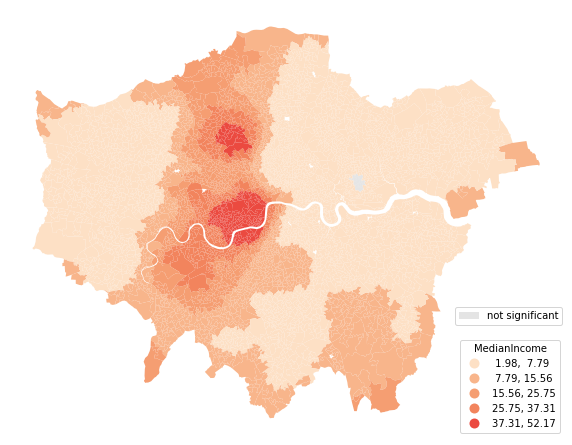

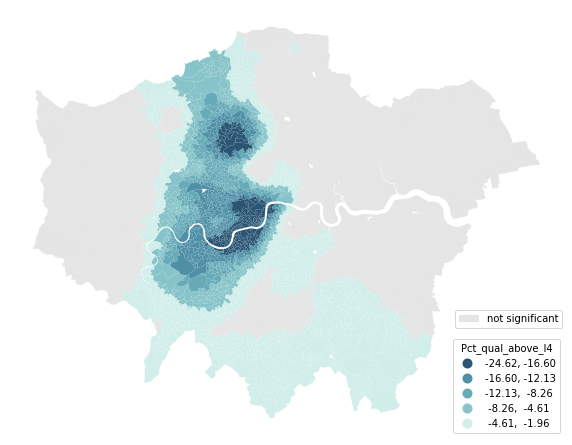

In [12]:

insig=[Patch(facecolor='grey',alpha=.2,label='not significant')]

# Fig 5 and fig 8 (sequential)
# Fig 5
fig,ax=plt.subplots(1,figsize=(10,8))
result_gdf[result_gdf['MedianIncome']==0].plot(color='grey',ax=ax,alpha=.2)

result_gdf[result_gdf['MedianIncome']!=0].\
    plot(column='MedianIncome',cmap=cartos.Peach_5.mpl_colormap,scheme='fisherjenks',
         legend=True,legend_kwds={'loc':'lower right','title':'MedianIncome'},ax=ax)

ax.axis('off')
fig.legend(handles=insig,loc='center',bbox_to_anchor=(0.821,0.34))

plt.savefig('graph/fig5.png',dpi=200,bbox_inches='tight',facecolor=None)
plt.show()

# Fig 8
fig,ax=plt.subplots(1,figsize=(10,8))
result_gdf[result_gdf['Pct_qual_above_l4']==0].plot(color='grey',ax=ax,alpha=.2)

result_gdf[result_gdf['Pct_qual_above_l4']!=0].\
    plot(column='Pct_qual_above_l4',cmap=cartos.Teal_5_r.mpl_colormap,scheme='fisherjenks',
         legend=True,legend_kwds={'loc':'lower right','title':'Pct_qual_above_l4'},ax=ax)

ax.axis('off')
fig.legend(handles=insig,loc='center',bbox_to_anchor=(0.821,0.335))

plt.savefig('graph/fig8.png',dpi=200,bbox_inches='tight',facecolor=None)
plt.show()

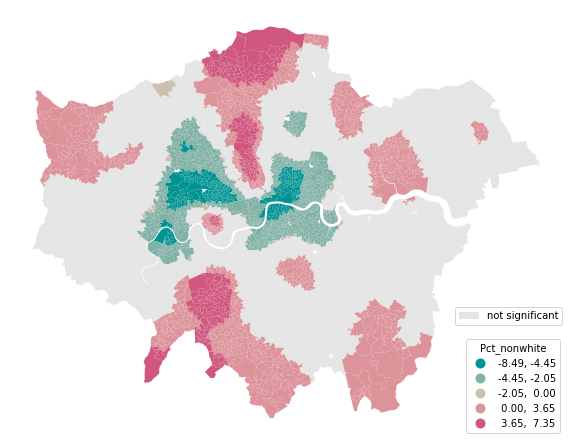

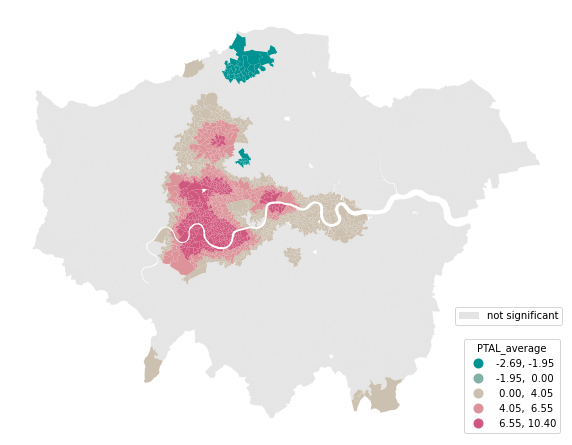

In [13]:
# Fig 6 and fig 7 (diverging)
ud_bins={0:[-4.45,-2.05,0,3.65,7.35],
         1:[-1.95,0,4.05,6.55,10.4]}

for i,row in enumerate(f_est.T[2:-1]):
    fig,ax=plt.subplots(1,figsize=(10,8))
    temp = result_gdf.assign(toplot=f_est.T[i+2])
    temp.query('toplot==0').sort_values('toplot').\
        plot(color='grey',ax=ax,alpha=.2)

    temp.query('toplot!=0').sort_values('toplot').\
        plot('toplot',cmap=cartod.TealRose_6.mpl_colormap,ax=ax,legend=True,
             legend_kwds={'loc':'lower right','title':var_n[i+1]},
             scheme='userdefined',classification_kwds={'bins':ud_bins[i]})
    
    ax.axis('off')
    fig.legend(handles=insig,loc='center',bbox_to_anchor=(0.821,0.34))

    plt.savefig('graph/fig'+str(i+6)+'.png',dpi=200,bbox_inches='tight',facecolor=None)
    plt.show()

In [ ]:
fig,ax=plt.subplots(2,3,figsize=(20,10), subplot_kw=dict(aspect='equal'))
ax = ax.flatten()

titles = ['Intercept']+var_n

for i,row in enumerate(f_est.T):
    temp = result_gdf.assign(toplot=f_est.T[i])
    temp.query('toplot==0').sort_values('toplot').plot(color='grey',ax=ax[i],alpha=.2)

    temp.query('toplot!=0').sort_values('toplot').plot('toplot',cmap='viridis',ax=ax[i],legend=True)
    
    ax[i].set_title(titles[i], fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

result_gdf.assign(r2=m_gwr_fit.localR2).sort_values('r2').plot('r2',ax=ax[-1],legend=True,
                                                               vmin=0,vmax=1,cmap='viridis')
    
ax[-1].set_xticklabels([])
ax[-1].set_yticklabels([])
ax[-1].set_xticks([])
ax[-1].set_yticks([])
    
ax[-1].set_title('Local R2', fontsize=16)
    
fig.tight_layout()
    
plt.show()

In [ ]:
# calculate residuals
result_gdf['predy']=m_gwr_fit.predy
result_gdf['resid']=result_gdf['kMedianHP']-result_gdf['predy']

In [ ]:
# global moran's I of the GWR residuals
gwr_res_moran=Moran(result_gdf['resid'].values,weights)
print(gwr_res_moran.I)
print(gwr_res_moran.p_sim)

In [ ]:
# Fig 4
fig,ax=plt.subplots(1,figsize=(12,10))

result_gdf.plot(column='resid',cmap=pcd.PRGn_5.mpl_colormap,scheme='fisherjenks',
                legend=True,legend_kwds={'title':'GWR residuals','loc':'lower right'},ax=ax)

plt.figtext(x=0.15,y=0.25,
            s="Global Moran's I: "+str(round(gwr_res_moran.I,3))\
                +"\n(p-value < "+str(gwr_res_moran.p_sim)+")",
            fontsize=12,fontstyle='italic',color='#afb8c7')
ax.axis('off')

plt.savefig('graph/fig4.png',dpi=200,bbox_inches='tight',facecolor=None)
plt.show()

In [ ]:
# local moran's I
moran_loc_res=Moran_Local(result_gdf['resid'].values,weights,permutations=999)

In [ ]:
# lisa cluster map
fig,ax=plt.subplots(1,figsize=(15,12))
lisa_cluster(moran_loc_res,gdf,p=0.05,ax=ax)
plt.show()